## Saturation Limits Per Visit

This notebook demos a new stacker which calculates the point-source saturation limit per visit. This means now you have the point-source five sigma depth and the saturation limit available if desired. The saturation limit is calculated using an estimate for the full-well depth of 150,000 electrons - this what we're using as the limiting factor.

If you want to use the saturation limit information in a metric, you simply add the column to the necessary columns (using 'saturation_mag' as the column name). MAF will do the rest of the job of calling the stacker, using the default kwargs, to calculate the information. You can also define the stacker to use yourself (i.e. if you want to use non-default values for the kwargs), and add the stacker to the stackerList for the metricBundle - as per the usual procedure if you want to use a custom stacker. 

But here, I just run the stacker directly on the visits, so we can see what the distribution of saturation values looks like. The last few cells illustrate how the limiting magnitude varies - this is primarily driven by the range of seeing values, rather than skybrightness. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker

In [3]:
satStacker = stackers.SaturationStacker()

In [4]:
cols = ['seeingFwhmEff', 'filter', 'skyBrightness', 
        'visitExposureTime', 'numExposures', 'airmass', 'fiveSigmaDepth']

In [5]:
# Test example: 
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
darkskyMag = {'u': 22.960730, 'g': 22.257758, 'r': 21.196590, 'i': 20.477419, 'z': 19.599578, 'y': 18.610405}
d = pd.DataFrame(index=filterlist, columns=cols, dtype='float')
d['visitExposureTime'] = 30
d['numExposures'] = 2
d['airmass'] = 1.0
d['filter'] = d.index.values
d['seeingFwhmEff'] = 0.72
mags = [val for val in darkskyMag.values()]
d['skyBrightness'] = mags
d

,seeingFwhmEff,filter,skyBrightness,visitExposureTime,numExposures,airmass,fiveSigmaDepth
u,0.72,u,22.960730,30,2,1.0,NaN
g,0.72,g,22.257758,30,2,1.0,NaN
r,0.72,r,21.196590,30,2,1.0,NaN
i,0.72,i,20.477419,30,2,1.0,NaN
z,0.72,z,19.599578,30,2,1.0,NaN
y,0.72,y,18.610405,30,2,1.0,NaN


In [6]:
d = satStacker.run(d.to_records())
pd.DataFrame(d)

,index,seeingFwhmEff,filter,skyBrightness,visitExposureTime,numExposures,airmass,fiveSigmaDepth,saturation_mag
0,u,0.72,u,22.960730,30,2,1.0,NaN,14.112254
1,g,0.72,g,22.257758,30,2,1.0,NaN,15.463292
2,r,0.72,r,21.196590,30,2,1.0,NaN,15.234698
3,i,0.72,i,20.477419,30,2,1.0,NaN,14.945975
4,z,0.72,z,19.599578,30,2,1.0,NaN,14.548140
5,y,0.72,y,18.610405,30,2,1.0,NaN,13.769434


In [7]:
baseline = 'baseline_nexp2_v1.7_10yrs'
twi_neo = 'twi_neo_pattern1_v1.7_10yrs'
short_exp = 'short_exp_2ns_1expt_v1.5_10yrs'
runs = [baseline, twi_neo, short_exp]
opsdb = {}
rootDir = '/astro/store/pogo4/opsim/fbs_db/'
for r in runs:
    if r.startswith('baseline'):
        t = 'fbs_1.7/baseline'
    if r.startswith('twi_neo'):
        t = 'fbs_1.7/twi_neo'
    if r.startswith('short_exp'):
        t = 'fbs_1.5/short_exp'
    opsdb[r] = db.OpsimDatabase(os.path.join(rootDir, t, r+'.db'))

In [8]:
simdata = {}
for r in runs:
    simdata[r] = opsdb[r].fetchMetricData(cols)

In [9]:
for r in runs:
    print(simdata[r].shape)

(2045493,)
(3013478,)
(2536392,)


In [10]:
for r in runs:
    print(r)
    simdata[r] = satStacker.run(simdata[r])
    print(simdata[r].shape)

baseline_nexp2_v1.7_10yrs
(2045493,)
twi_neo_pattern1_v1.7_10yrs
(3013478,)
short_exp_2ns_1expt_v1.5_10yrs
(2536392,)


In [11]:
simdata['baseline_nexp2_v1.7_10yrs']['saturation_mag']

array([13.40539887, 13.43456863, 13.60987486, ..., 13.49403587,
       13.49365879, 13.56598286])

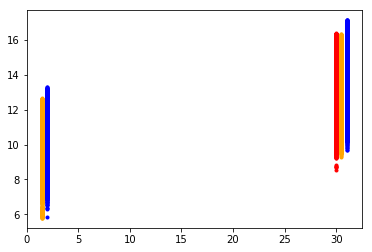

In [12]:
colors = ['red', 'orange', 'blue']
for i, r in enumerate(runs):
    plt.plot(simdata[r]['visitExposureTime']+i*.5, simdata[r]['saturation_mag'], 
             color=colors[i], linestyle='', marker='.')

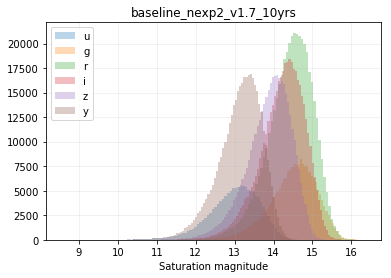

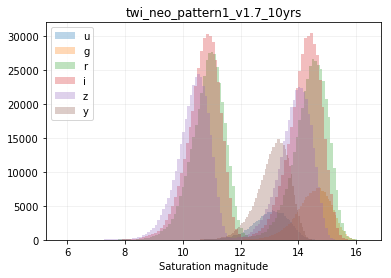

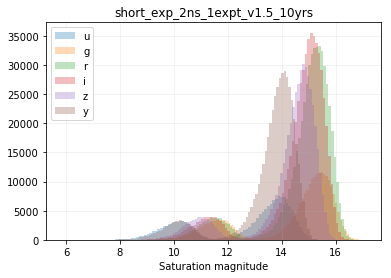

In [13]:
colors = {'u': 'cyan', 'g': 'g', 'r': 'orange', 'i': 'r', 'z': 'm', 'y': 'b'}
for r in runs:
    plt.figure()
    for f in colors:
        in_filt = np.where(simdata[r]['filter'] == f)[0]
        plt.hist(simdata[r]['saturation_mag'][in_filt], bins=100, alpha=0.3, label=f)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.title(r)
    plt.xlabel('Saturation magnitude')

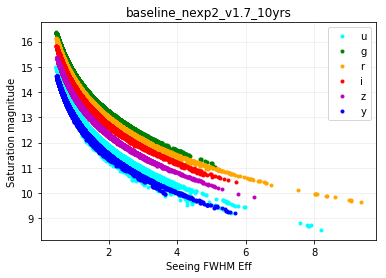

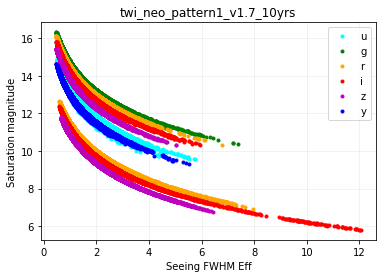

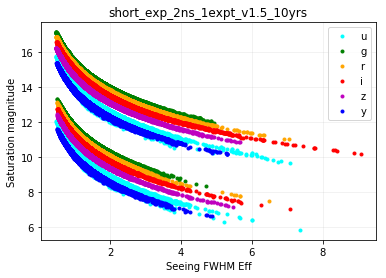

In [14]:
colors = {'u': 'cyan', 'g': 'g', 'r': 'orange', 'i': 'r', 'z': 'm', 'y': 'b'}
for r in runs:
    plt.figure()
    for f in colors:
        in_filt = np.where(simdata[r]['filter'] == f)[0]
        plt.plot(simdata[r]['seeingFwhmEff'][in_filt], simdata[r]['saturation_mag'][in_filt], 
                 linestyle='', marker='.', color=colors[f], label=f)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.2)
    plt.title(r)
    plt.xlabel('Seeing FWHM Eff')
    plt.ylabel('Saturation magnitude')

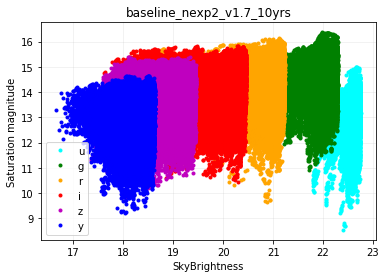

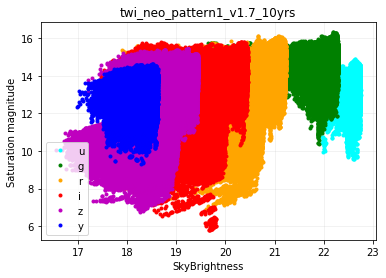

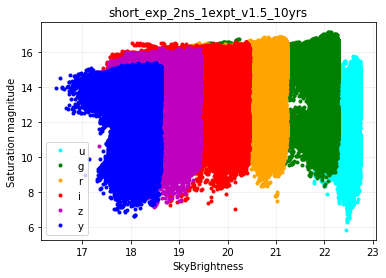

In [15]:
colors = {'u': 'cyan', 'g': 'g', 'r': 'orange', 'i': 'r', 'z': 'm', 'y': 'b'}
for r in runs:
    plt.figure()
    for f in colors:
        in_filt = np.where(simdata[r]['filter'] == f)[0]
        plt.plot(simdata[r]['skyBrightness'][in_filt], simdata[r]['saturation_mag'][in_filt], 
                 linestyle='', marker='.', color=colors[f], label=f)
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.2)
    plt.title(r)
    plt.xlabel('SkyBrightness')
    plt.ylabel('Saturation magnitude')

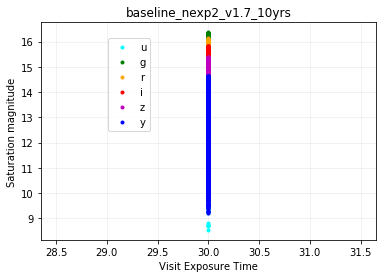

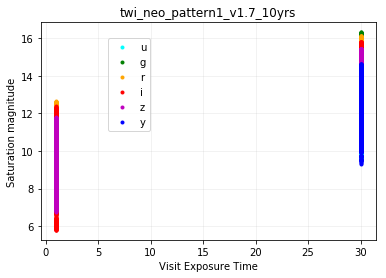

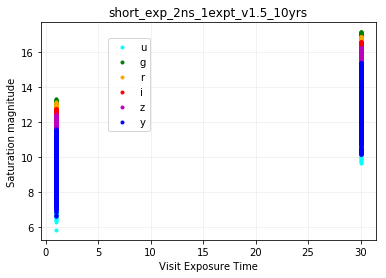

In [16]:
colors = {'u': 'cyan', 'g': 'g', 'r': 'orange', 'i': 'r', 'z': 'm', 'y': 'b'}
for r in runs:
    plt.figure()
    for f in colors:
        in_filt = np.where(simdata[r]['filter'] == f)[0]
        plt.plot(simdata[r]['visitExposureTime'][in_filt], simdata[r]['saturation_mag'][in_filt], 
                 linestyle='', marker='.', color=colors[f], label=f)
    plt.legend(loc=(0.2, 0.5))
    plt.grid(True, alpha=0.2)
    plt.title(r)
    plt.xlabel('Visit Exposure Time')
    plt.ylabel('Saturation magnitude')

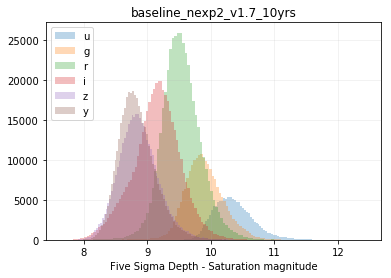

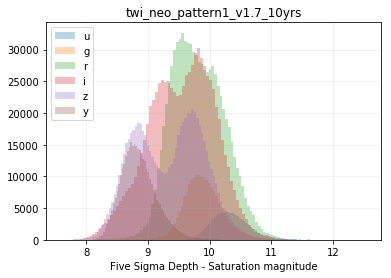

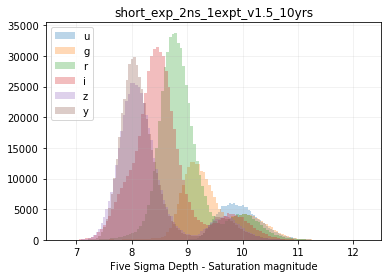

In [18]:
colors = {'u': 'cyan', 'g': 'g', 'r': 'orange', 'i': 'r', 'z': 'm', 'y': 'b'}
for r in runs:
    plt.figure()
    for f in colors:
        in_filt = np.where(simdata[r]['filter'] == f)[0]
        plt.hist((simdata[r]['fiveSigmaDepth'][in_filt] - simdata[r]['saturation_mag'][in_filt]), 
                 bins=100, alpha=0.3, label=f)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.title(r)
    plt.xlabel('Five Sigma Depth - Saturation magnitude')